# 시계열 예측 튜토리얼(Time Series Forecasting Tutorial)

참고 : https://www.tensorflow.org/tutorials/structured_data/time_series

---
### Setup

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import datetime
import IPython
import IPython.display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# M1 개발환경에서 TensorFlow를 사용하기 위한 코드입니다.
# M1 개발환경이 아닐경우 생략합니다.
from tensorflow.python.compiler.mlcompute import mlcompute
#tf.compat.v1.disable_eager_execution()
mlcompute.set_mlc_device(device_name = 'any')

---
## 수집(Acquision)

이번 시계열 예측 튜토리얼에서 Jena Climate dataset(recorded by the [Max Planck Institute for Biogeochemistry][link])을 사용하였습니다.

이 데이터는 독일 Jena지역에서 2009년 1월 10일부터 2016년 12월 31일까지 10분 간격으로 측정된 14가지 특성으로 이루어져있습니다.


[link]: https://www.bgc-jena.mpg.de/wetter/

In [3]:
df = pd.read_csv('jena_climate_2009_2016.csv')

---
## 점검 및 탐색(Inspection and exploratin)

데이터 구조를 파악하기 위해, 처음 5개의 행만 출력하여 데이터를 확인합니다.

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


데이터는 시간부분을 제외하고 온도, 대기압, 습도, 풍속, 풍향 등 14개의 특성을 가지고 있습니다. 데이터는 10분 간격으로 나타나있으며 하루에 144개의 데이터가 기록됩니다.

`df.describe()`을 사용하여 데이터의 분포와 통계를 살펴겠습니다. 그리고 몇 가지 특성에 대해서는 시각화를 하기 위해 그래프로 나타내겠습니다.

In [5]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [6]:
# 데이터프레임 d.m.Y H:M:S 형식으로 표현되어있는 Date Time 열을 Y-m-d H:M:S 형식으로 변경하고 따로 저장합니다.
date_time = pd.to_datetime(df.pop('Date Time'), format = '%d.%m.%Y %H:%M:%S')

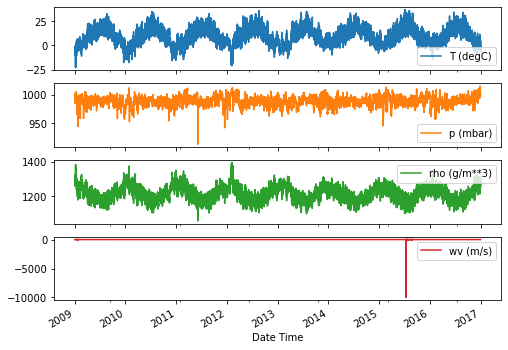

In [7]:
# matplotlib 차트의 기본 설정
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] =False

# 기온(T), 대기압(mbar), 공기밀도(rho), 풍속(wv) 네 가지 특성에 대해 그래프로 나타냅니다.
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)', 'wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

`df.describe()`과 그래프를 통하여 데이터를 확인한 결과, 다른 특성들에서는 시간에 따른 변화가 나타나지만 풍속과 최대풍속을 나타내는 특성인 `wv` , `max. wv`에 이상이 있다고 판단됩니다.

---
## 전처리 및 정제(Preprocessing and Cleaning)

데이터 구조에 대한 파악 이후 학습 진행에 용이하도록 데이터 전처리를 수행합니다. 이전 단계에서 데이터를 살펴본 결과, `wv`, `max. wv`특성에서 최소값 `-9999`이 나타나는 것을 확인 할 수 있었습니다.

풍향에 대한 특성 `wd`가 따로 존재하기 때문에 풍속의 값은 스칼라 값으로 `>=0`의 값을 가져야합니다. 따라서 해당 값을 `0`으로 대체하겠습니다.

In [8]:
wv = df['wv (m/s)']
# wv에서 -9999.0 값을 가지는 열의 index를 minus_wv에 저장합니다.
minus_wv = wv == -9999.0
# wv에서 minus_wv 인덱스에 해당하는 값들을 0.0으로 변환합니다.
wv[minus_wv] = 0.0

# wv에 대해 수행했던 작업을 max. wv에도 수행합니다.
max_wv = df['max. wv (m/s)']
minus_max_wv = max_wv == -9999.0
max_wv[minus_max_wv] = 0.0

음수값 `-9999.0`이 나타나던 `wv`, `max. wv`값을 0으로 대체하였으니, 다시 그래프를 그려보겠습니다.

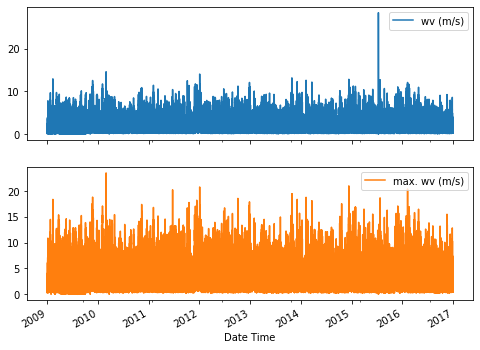

In [9]:
plot_cols = ['wv (m/s)', 'max. wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

---
데이터의 마지막 특성은 `wd (deg)`로 바람의 방향을 나타내고 있습니다. 해당 특성에 대해서 그래프로 나타내면 다음과 같습니다.

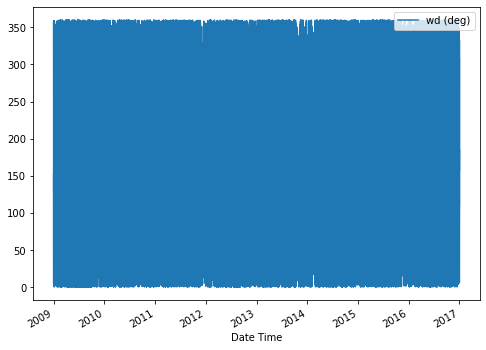

In [10]:
plot_cols = ['wd (deg)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

학습을 진행할 때 모델에 적절한 형식의 데이터를 전달해야하는데, 바람의 방향에 대한 그래프를 확인해보면 모델 입력으로 좋지 않은 모습을 나타내고 있습니다.

이는 바람의 방향을 각도로 표시하였기 때문에 나타나는 현상입니다. 360도와 0도는 사실상 같은 값이기 때문에 동일한 특성을 가져야 합니다.

이러한 문제를 해결하기 위해서 풍향과 풍속 데이터를 합쳐 바람에 대한 정보를 하나의 벡터로 나타내도록 하겠습니다.

In [11]:
# 풍속과 관련되어있는 데이터를 wv, max_wv로 저장합니다.
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# 풍향의 경우 각도로 표시되어있는 값을 라디안 값으로 변환하여 저장합니다.
wd_rad = df.pop('wd (deg)') * np.pi / 180

# 풍속 데이터, 라디안값으로 변환한 풍향데이터, 삼각함수를 사용하여
# 풍속과 풍향을 벡터값으로 합쳐 데이터프레임에 추가합니다.
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

df['max Wx'] = max_wv * np.cos(wd_rad)
df['max Wy'] = max_wv * np.sin(wd_rad)

벡터값으로 변환한 데이터를 그래프로 그려보면 다음과 같습니다.

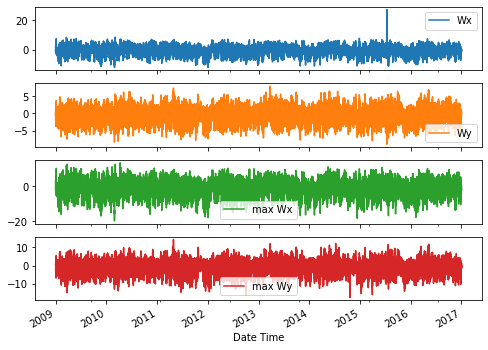

In [12]:
plot_cols = ['Wx', 'Wy', 'max Wx', 'max Wy']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

풍속에 관한 특성인 `wv`, `max. wv`에 대해서 방향을 나타내는 특성인 `wd`를 조합하여 벡터값으로 변환하여 그래프로 표현하였습니다. 이전 풍향을 그대로 나타냈을 때 보다는 더 의미있는 데이터로 변환되었습니다.

---
다음으로 데이터를 세 부분으로 분할합니다. 세 부분의 역할은 각각 훈련데이터, 검증데이터, 테스트데이터 입니다.

각각의 데이터의 비율은 훈련데이터 70%, 검증데이터 20%, 테스트데이터 10%로 분할하였습니다.

In [13]:
# 훈련데이터, 검증데이터, 테스트데이터 분할
n = len(df)
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

# 특성의 수에 대해서 변수로 정의
num_features = df.shape[1]

데이터를 사용하여 훈련을 진행하기 전에 각각의 특성들은 서로다른 범위의 값을 가지기 때문에 정규화를 수행합니다.

훈련데이터의 평균, 표준편차를 사용하여 정규화를 수행하고, 검증데이터와 테스트데이터는 훈련데이터의 정보를 활용하여 정규화를 수행합니다.

In [14]:
# 훈련데이터의 평균과 표준편차
train_mean = train_df.mean()
train_std = train_df.std()

# 훈련데이터, 검증데이터, 테스트데이터 정규화
train_scaled = (train_df - train_mean) / train_std
val_scaled = (val_df - train_mean) / train_std
test_scaled = (test_df - train_mean) / train_std

---
## 모델링 및 훈련(Modeling and Training)

### 데이터 창(Data windows)

이번 튜토리얼에서는 연속된 데이터를 기반으로 미래를 예측하는 시계열 학습입니다. 이러한 시계열 학습을 수행할 때, 데이터 창(window)를 기반으로 예측을 수행합니다.

데이터 창(window)의 주요 특징과 역할은 다음과 같습니다.
- 입력(input)과 라벨(label)에 대해서 타임스텝(time-step)을 의미하는 너비(Width) 정의
- 각각의 시간 사이의 간격(offset) 정의

데이터 창(window)의 예시는 다음과 같습니다.

1. 12시간의 기록이 주어졌을 때, 이를 활용하여 앞으로 12시간 후의 미래를 단일 예측하기 위해서는 다음과 같이 창(window)이 필요합니다.
![Data window example 1](images/00_window.PNG)

2. 5시간의 기록이 주어졌을 때, 이를 활용하여 앞으로 1시간 후의 미래를 단일 예측하기 위해서는 다음과 같은 창(window)이 필요합니다.
![Data window example 2](images/01_window2.PNG)

이러한 데이터 창(window)을 정의하는 `Window` 클래스를 정의하겠습니다.

해당 클래스에서는 데이터에 대해서 `(features, labels)`로 분할합니다. 또한, 입력(input)과 라벨(label)에 대한 너비(width), 시간 사이의 간격(offset)을 입력 받습니다. 이를 활용하여 이번 튜토리얼에서 사용하는 모델 유형에 따라 다양한 데이터 창(window)을 생성할 수 있도록 하겠습니다.

In [15]:
# 데이터 창(window)를 생성하는 클래스를 정의합니다.
class Window():
    # 클래스에서 입력받을 값들에 대해서 정의합니다.
    # 데이터의 경우 따로 입력하지 않을 경우 앞서 정규화된 데이터를 사용하게 합니다.
    def __init__(self, input_width, label_width, offset,
                train_data = train_scaled, val_data = val_scaled, test_data = test_scaled,
                label_columns = None) :
        # 입력받은 데이터를 저장합니다.
        self.train_data = train_scaled
        self.val_data = val_scaled
        self.test_data = test_scaled
        
        # 라벨(label) 열(column)에 대해 인덱스 작업을 수행합니다.
        # 라벨 열이 입력될 경우 그대로 사용하고, 그렇지 않은 경우 클래스 내에서 지정합니다.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name : i for i, name in
                                         enumerate(label_columns)}
        self.column_indices = {name : i for i, name in
                              enumerate(train_data.columns)}
        
        # 데이터 창(window) 파라미터에 대한 적업을 수행합니다.
        self.input_width = input_width
        self.label_width = label_width
        self.offset = offset
        
        self.total_width = input_width + offset
        
        # input_width의 크기만큼 input_slice의 크기를 지정합니다.
        self.input_slice = slice(0, input_width)
        # total_width에 대해서 input_slice 크기에 해당하는 만큼 인덱스를 지정합니다.
        self.input_indices = np.arange(self.total_width)[self.input_slice]
        
        # label이 시작되는 위치를 total_width에서 label_width를 빼는 계산을 통하여 지정합니다.
        self.label_start = self.total_width - self.label_width
        # input에 대해서 수행했던 작업을 label에 대해서도 수행합니다.
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_width)[self.labels_slice]
    
    # 클래스 안에서 지정한 값들에 대해서 return합니다.
    def __repr__(self) :
        return '\n'.join([
            f'Total Width : {self.total_width}',
            f'Input indices : {self.input_indices}',
            f'Label indices : {self.label_indices}',
            f'Label column name(s) : {self.label_columns}'])

`Window`클래스를 이용하여 앞서 예시로 들었던 두 가지 경우에 대해서 데이터 창(window)를 생성하겠습니다.

In [16]:
# 데이터 창(window) 첫 번째 예시를 생성합니다.
example_window1 = Window(input_width = 12, label_width = 1, offset = 12,
                        label_columns = ['T (degC)'])
example_window1

Total Width : 24
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices : [23]
Label column name(s) : ['T (degC)']

In [17]:
# 데이터 창(window) 두 번째 예시를 생성합니다.
example_window2 = Window(input_width = 5, label_width = 1, offset = 1,
                        label_columns = ['T (degC)'])
example_window2

Total Width : 6
Input indices : [0 1 2 3 4]
Label indices : [5]
Label column name(s) : ['T (degC)']

---
다음으로는 `Window`클래스에 추가할 `Split`함수를 정의합니다. 이 함수는 데이터를 입력(input)부분과 라벨(label)부분으로 나누어줍니다.

위의 예제 `example_window2`에 대해서 `Split`함수를 적용시키면 다음과 같이 나누어집니다.
![Split](images/02_split.PNG)

In [18]:
# split함수 정의
def Split(self, features) :
    # Window에서 정의된 input_slice, labels_slice값을 이용하여 inputs, labels를 나누어 줍니다.
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis = -1)
        
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

# Window 클래스에 Split 함수를 추가합니다.
Window.Split = Split

데이터 창(window)의 두 번째 예시였던 `example_window2`를 활용하여 예시로 사용될 입력(input)과 라벨(label)을 정의합니다.

예시로 사용될 데이터는 `train_scaled`의 첫 행부터 `example_window2.total_width`인 6행, 100번째 행부터 6행, 200번째 행부터 6행씩 총 3개의 batch를 사용하겠습니다.

In [19]:
sample_data = tf.stack([np.array(train_scaled[:example_window2.total_width]),
                    np.array(train_scaled[100 : 100 + example_window2.total_width]),
                    np.array(train_scaled[200 : 200 + example_window2.total_width])])

example_inputs, example_labels = example_window2.Split(sample_data)

# print를 통한 데이터 shape 확인
print('Shapes : (batch, time, features)')
print(f'Window shape : {sample_data.shape}')
print(f'Input shape : {example_inputs.shape}')
print(f'Labels shape : {example_labels.shape}')

Shapes : (batch, time, features)
Window shape : (3, 6, 15)
Input shape : (3, 5, 15)
Labels shape : (3, 1, 1)


`print`를 통하여 출력되는 값을 통하여 전체적인 데이터 창(window)이 입력(input)과 라벨(label)로 나누어지는것을 확인할 수 있습니다.

`Split`을 사용하여 정의된 `example_inputs`, `example_labels`를 `example_window2`에 추가하겠습니다.

In [20]:
example_window2.example = example_inputs, example_labels

---
다음으로 시각화를 하기위한 `plot`함수를 정의하고, `Window` 클래스에 추가하겠습니다.

In [21]:
def plot(self, model=None, plot_col = 'T (degC)', max_subplots = 3) :
    
    # inputs, labels를 불러옵니다
    inputs, labels = self.example
    plt.figure(figsize = (12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n) :
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label = 'Inputs', marker = '.', c = 'k' , zorder = 10)
        
        if self.label_columns :
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else :
            label_col_index = plot_col_index
            
        if label_col_index is None :
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                   edgecolors = 'k', label = 'Labels', c = 'g', s = 64)
        
        # 학습시킨 모델이 있을 경우 모델의 predict값을 plot합니다.
        if model is not None :
            pred = model(inputs)
            plt.scatter(self.label_indices, pred[n, :, label_col_index],
                       marker = 'X', edgecolors = 'royalblue', label = 'Predictions',
                       c = 'b', s =64)
            
        if n == 0 :
            plt.legend()
        
    plt.xlabel('Time [10m]')

# Window 클래스에 plot 함수를 추가합니다.
Window.plot = plot

`plot`을 사용하여 `example_window2`에 대한 입력(input)과 라벨(label)을 그래프로 나타냅니다.

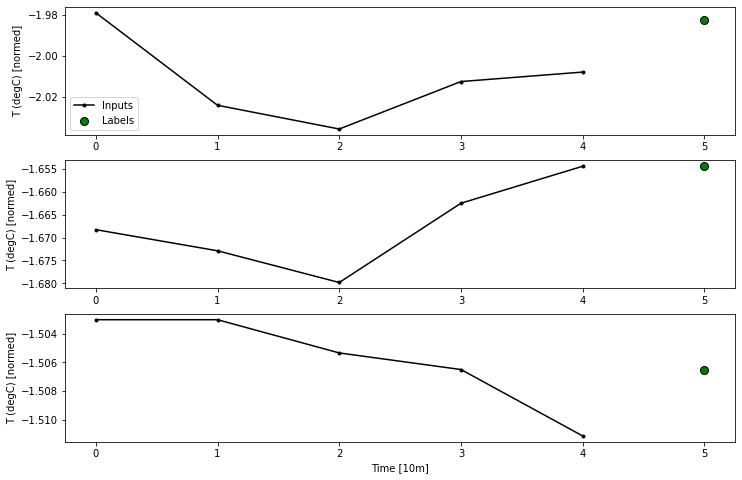

In [22]:
example_window2.plot()

`plot`에 추가적인 입력이 없는 경우, 기본적으로 `T deg(C)`에 대해 그래프를 그립니다. 만약 다른 특성에 대한 그래프를 그리려면 `plot_col`을 지정해줍니다. 다만, 이 경우 다른 특성에 대해 입력(input)과 라벨(label)을 구분하지 않았기 때문에, 그래프에서도 `T deg(C)`를 그린 그래프처럼 입력(input)과 라벨(label)에 대한 구분이 존재하지 않습니다.

이를 활용하여 `p (mbar)`에 대한 그래프를 그려보겠습니다.

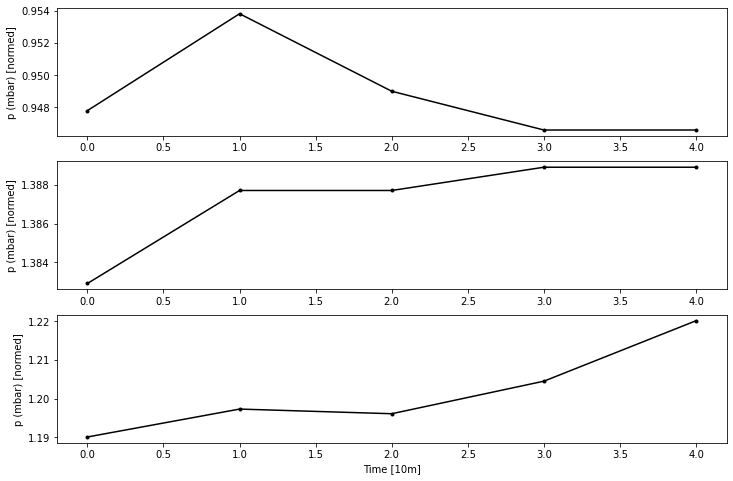

In [23]:
example_window2.plot(plot_col = 'p (mbar)')

---
마지막으로 `Window`클래스에 추가할 `make_dataset`함수를 정의합니다.

`make_dataset`함수는 `DataFrame`에 대해서 `preprocessing.timeseries_dataset_from_array`함수를 사용하여, 데이터를 `(input_window, label_window)`로 이루어져 있는 `tf.data.Dataset`으로 변환합니다.

In [24]:
def make_dataset(self, data) :
    data = np.array(data, dtype = np.float32)
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data = data, targets = None, sequence_length = self.total_width,
        sequence_stride = 1, shuffle = True, batch_size = 32)
    
    dataset = dataset.map(self.Split)
    
    return dataset

Window.make_dataset = make_dataset

`make_dataset`을 사용하고, 변수들의 호환성을 위하여 `@property`를 사용합니다.

In [25]:
@property
def train(self) :
    return self.make_dataset(self.train_data)

@property
def val(self) :
    return self.make_dataset(self.val_data)

@property
def test(self) :
    return self.make_dataset(self.test_data)

@property
def example(self) :
    result = getattr(self, '_example', None)
    if result is None :
        result = next(iter(self.train))
        self._example = result
    return result


Window.train = train
Window.val = val
Window.test = test
Window.example = example

---
## 단일 스텝 모델(Single step models)

현재 튜토리얼에서 사용하고 있는 유형의 데이터를 기반으로 만들 수 있는 갖아 간단한 모델은, 현재 정보를 기반으로 바로 다음의 단일 특성 값을 예측하는 모델입니다.

따라서 10분 후의 `T (degC)`값을 예측하는 모델을 빌드하겠습니다.

![Single Step Models](images/03_singlestepmodel.PNG)

먼저 `T (degC)`한 개의 입력(input)을 받아서, 1타임스텝 이후의 값을 예측하는 창(window)를 생성합니다.

In [26]:
single_step_window = Window(input_width = 1, label_width = 1, offset = 1, label_columns = ['T (degC)'])
single_step_window

Total Width : 2
Input indices : [0]
Label indices : [1]
Label column name(s) : ['T (degC)']

---
## Baseline

훈련모델을 빌드하기 전에, 추후 빌드할 여러가지 모델들에 대한 성능을 비교하기 위한 기준(baseline)을 정해두는 것이 좋습니다.

처음은 모든 특성의 현재 값을 고려하여 10분 미래의 온도를 예측하는 것입니다. 현재 값에는 현재 온도`T (degC)`가 포함되어있는데, 이를 반환하여 온도가 현재 값과 변화 없이 유지되는 모델을 빌드하겠습니다.

온도의 경우 급격하게 변하지 않기 때문에 현재 온도를 유지하는 모델을 기준(baseline)으로 정하는것은 합리적입니다. 물론, 더 먼 미래를 예측하게되면 이 기준(baseline)모델의 예측 효과는 감소할 것입니다.

![Baseline](images/04_baseline.PNG)

In [27]:
# 기준(baseline)모델인 Baseline 클래스 정의
class Baseline(tf.keras.Model) :
    def __init__(self, label_index = None) :
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs) :
        if self.label_index is None :
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [28]:
# 각 열(column)의 인덱스 정의
column_indices = {name : i for i, name in enumerate(df.columns)}

In [29]:
# WARNING:tensorflow:AutoGraph could not transform
# AutoGraph와의 충돌로 인한 WARNING 메세지를 감추는 코드.
# 학습에는 지장이 없으나, 보기에 좋지않아 사용.
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

baseline = Baseline(label_index = column_indices['T (degC)'])

baseline.compile(loss = tf.losses.MeanSquaredError(),
                metrics = [tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baesline'] = baseline.evaluate(single_step_window.test, verbose = 0)

 103/2629 [>.............................] - ETA: 2s - loss: 7.4037e-04 - mean_absolute_error: 0.0176 

2021-08-03 15:37:38.426805: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-03 15:37:38.426957: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


2629/2629 [==============================] - 2s 828us/step - loss: 7.7291e-04 - mean_absolute_error: 0.0180


`single_step_window`에 대해서 기준(baseline) 모델을 적용시킨 예측 그래프는 다음과 같습니다.

그래프에서 검은색점과 선은 입력(input), 초록색 O 표시는 실제값인 라벨(label), 파란색 X 표시는 예측값을 나타냅니다. 

앞서 설명했던 것과 같이 기준(baseline) 모델에서는 이전의 입력(input)값을 예측값으로 그대로 사용하는 것을 확인할 수 있습니다.

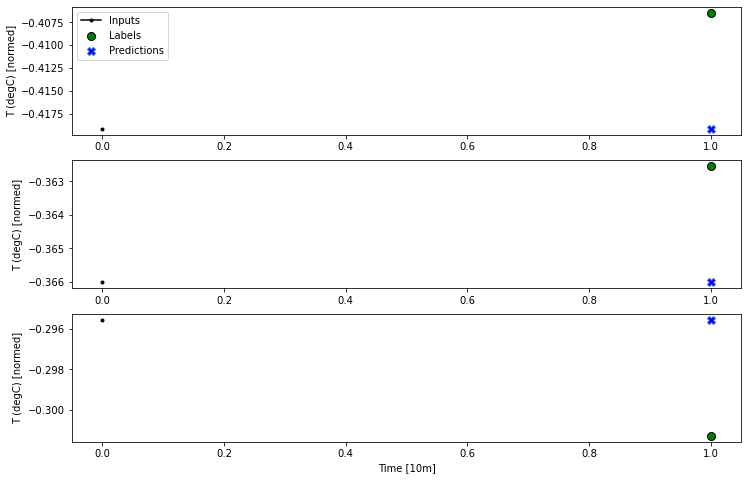

In [30]:
single_step_window.plot(baseline)

---
`input_width`과 `label_width`의 크기를 조절, 즉 `batch size`를 조절하여 한번에 여러개의 결과를 예측할 수 있습니다. 이는 모델의 동작 방식은 변화시키지 않으며, 각 예측은 타임스텝 사이의 상호 작용 없이 독립적으로 이루어집니다. 이렇게 확장시킨 데이터 창(window)을 `wide_window`로 정의하겠습니다.

![Baseline2](images/05_baseline2.PNG)

In [31]:
# inpit_width, label_width의 크기를 12로 설정하여 2시간 분량의 데이터 창 생성.
wide_window = Window(input_width = 12, label_width = 12, offset = 1,
                    label_columns = ['T (degC)'])
wide_window

Total Width : 13
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices : [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s) : ['T (degC)']

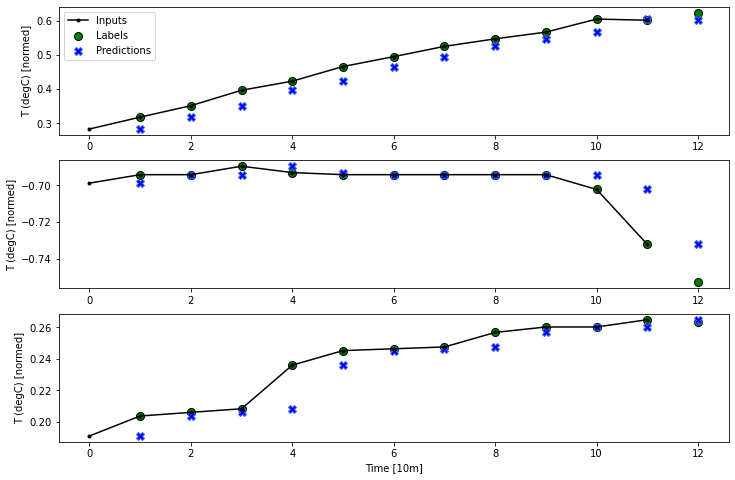

In [32]:
wide_window.plot(baseline)

---
## 선형 모델(Linear model)
이번 튜토리얼 데이터에 적용할 수 있는 가장 간단한 모델은 입력(input)과 출력(output)사이에 선형 모델(linear model)을 추가하는것입니다.

![Linear Model](images/06_linearmodel.PNG)

선형모델은 다음과 같이 나타냅니다.

`tf.keras.layers.Dense`를 사용하여 모델을 생성하였지만, `layers.Dense`에 `activation`을 추가하지 않는다면 선형 모델과 동일한 역할을 하게됩니다.

In [33]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units = 1)])

모델을 훈련하기 이전에 이번 튜토리얼에서는 다양한 모델에 대해서 훈련을 진행할 예정이니, 편의를 위하여 훈련과정을 하나의 함수로 정의합니다.

In [34]:
max_epochs = 20

def model_fit(model, window, patience = 2) :
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                     patience = patience,
                                                     mode = 'min')
    
    model.compile(loss = tf.losses.MeanSquaredError(),
                 optimizer = tf.optimizers.Adam(),
                 metrics = [tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs = max_epochs,
                       validation_data = window.val,
                       callbacks = [early_stopping])
    return history

정의한 `model_fit`함수를 활용하여 모델을 훈련하고 성능을 평가합니다.

In [35]:
history = model_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose = 0)

Epoch 1/20
9200/9200 [==============================] - 10s 1ms/step - loss: 0.1672 - mean_absolute_error: 0.1651 - val_loss: 0.0011 - val_mean_absolute_error: 0.0243
Epoch 2/20
9200/9200 [==============================] - 9s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0228 - val_loss: 8.7217e-04 - val_mean_absolute_error: 0.0205
Epoch 3/20
9200/9200 [==============================] - 10s 1ms/step - loss: 8.6586e-04 - mean_absolute_error: 0.0201 - val_loss: 7.8929e-04 - val_mean_absolute_error: 0.0192
Epoch 4/20
9200/9200 [==============================] - 11s 1ms/step - loss: 8.6094e-04 - mean_absolute_error: 0.0200 - val_loss: 8.6856e-04 - val_mean_absolute_error: 0.0209
Epoch 5/20
2629/2629 [==============================] - 2s 873us/step - loss: 8.1488e-04 - mean_absolute_error: 0.0197 1s - loss: 7.8377e-04 -  - ETA: 0s - loss: 8.1670e-04 - mean_absolute_erro


`single_step_window`에 대해서 `linear`모델을 적용시킨 그래프는 다음과 같습니다.

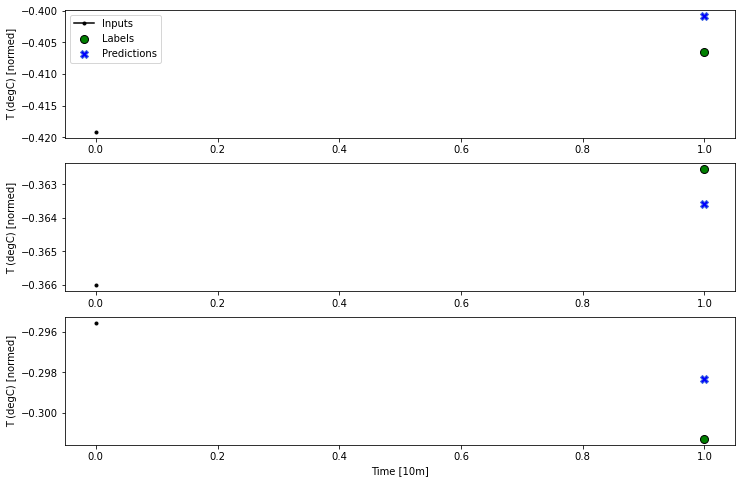

In [36]:
single_step_window.plot(linear)

`baseline`모델과 마찬가지로 선형 모델(linear model)도 넓은 범위에 대해서 결과를 예측할 수 있습니다. 이러한 방식으로 모델은 연속적인 타임스텝에 대해 일렬의. 독립적인 예측을 수행할 수 있습니다. 선형 모델(linear model)에서도 마찬가지로 각 타임스텝 및 예측 사이에 상호작용은 존재하지 않습니다.

![Linear Model2](images/07_linearmodel2.PNG)

이를 활용하여 `wide_window`를 사용하여 `linear`에 대한 예측값을 나타내겠습니다.

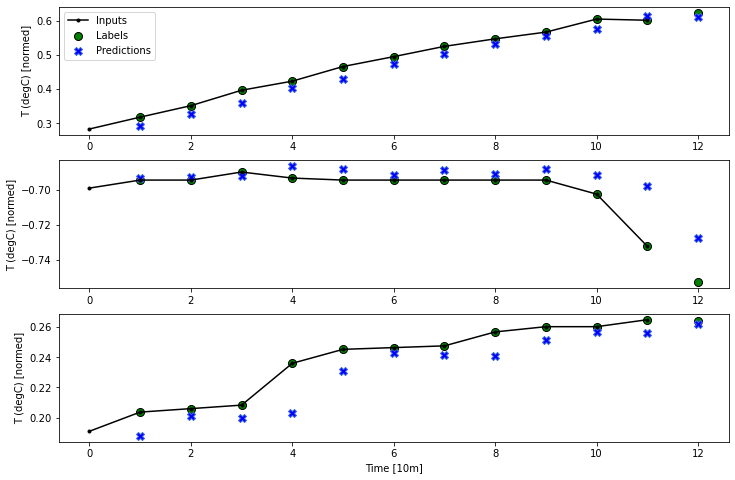

In [37]:
wide_window.plot(linear)

선형 모델(linear model)의 장점은 훈련 및 해석이 상대적으로 간단하다는 것입니다.

이번 훈련에서 사용된 모델의 `layer`에서 각 입력(input) 특성(feature)에 대한 가중치(weight)를 불러와 확인해보겠습니다. 

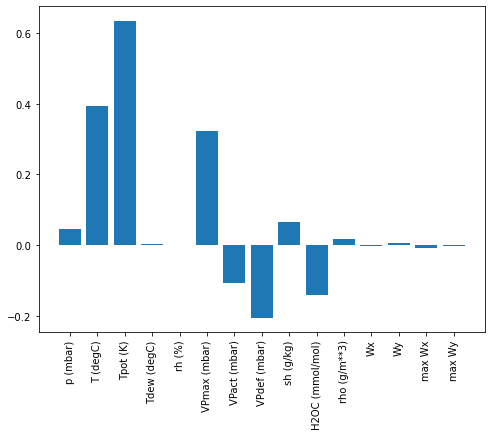

In [38]:
plt.bar(x = range(len(train_scaled.columns)),
       height = linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_scaled.columns)))
_ = axis.set_xticklabels(train_scaled.columns, rotation = 90)

이를 통하여 어떠한 변수에 많은 가중치(weight)를 두고있는지를 확인할 수 있습니다.

다만, 이는 초기상태에 따라서 변수에 대한 가중치가 매번 달라질 수 있습니다.

---
## Dense
여러 타임스텝에 대해 상호작용하는 모델을 적용하기 전에, 더 깊고(deep) 강력한 단일 스텝 모델의 성능을 확인해보겠습니다.

다음 모델은 입력(input)과 출력(output)사이에 몇 개의 `Dense`층을 쌓는 모델이며, 이 점을 제외하면 앞서 수행했던 `linear`모델과 크게 다르지 않습니다.

In [39]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 1)])

history = model_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose = 0)

Epoch 1/20
9200/9200 [==============================] - 12s 1ms/step - loss: 0.0063 - mean_absolute_error: 0.0364 - val_loss: 8.6550e-04 - val_mean_absolute_error: 0.0202
Epoch 2/20
9200/9200 [==============================] - 12s 1ms/step - loss: 9.8075e-04 - mean_absolute_error: 0.0220 - val_loss: 8.7356e-04 - val_mean_absolute_error: 0.0208
Epoch 3/20
9200/9200 [==============================] - 12s 1ms/step - loss: 9.1525e-04 - mean_absolute_error: 0.0210 - val_loss: 7.7635e-04 - val_mean_absolute_error: 0.0186
Epoch 4/20
9200/9200 [==============================] - 13s 1ms/step - loss: 8.9353e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0010 - val_mean_absolute_error: 0.0217
Epoch 5/20
2629/2629 [==============================] - 2s 914us/step - loss: 8.4904e-04 - mean_absolute_error: 0.0202


`dense`모델에 대해 `single_step_window`와 `wide_window`에 대해 그래프를 그리면 다음과 같습니다.

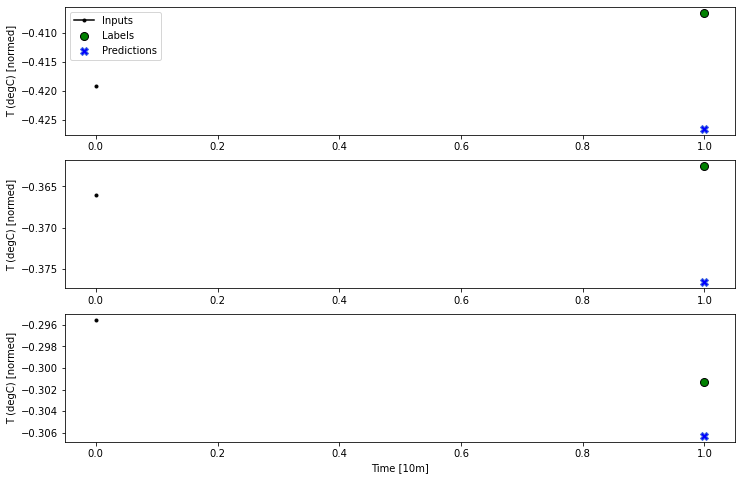

In [40]:
single_step_window.plot(dense)

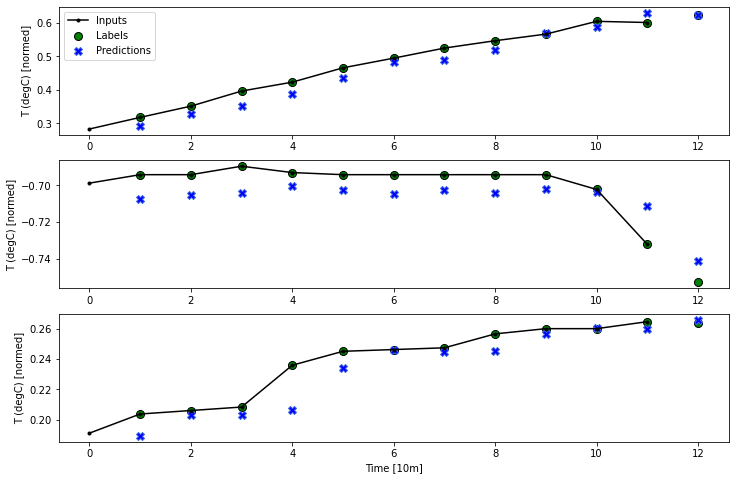

In [41]:
wide_window.plot(dense)

---
## Multi-step dense

단일 스텝 모델의 경우, 시간에 따라 입력(input)이 어떻게 변하는지 확인할 수 없습니다. 이 문제를 해결하기 위해서는 모델이 예측을 수행할 때 여러 타임스텝을 이용해야합니다.

![Multi-step dense](images/08_multistepdense.PNG)

이전까지 진행하였던 `baseline`, `linear`, `dense`모델의 경우 각 타임스텝에 대해서 독립적으로 처리했습니다. 이번 다중 스텝 모델의 경우 출력(output) 하나를 생성하기 위해서 여러 타임스텝을 입력(input)으로 사용합니다.

다중 스텝 모델을 생성하기 위하여 3개의 타임스텝(30분) 입력(input)과 이를 통하여 1개의 라벨(label)을 생성하는 `Window`를 만듭니다.

In [42]:
multi_window = Window(input_width = 3, label_width = 1,
                      offset = 1, label_columns = ['T (degC)'])
multi_window

Total Width : 4
Input indices : [0 1 2]
Label indices : [3]
Label column name(s) : ['T (degC)']

이에대한 입력(input)과 라벨(label)을 그래프로 그려보면 다음과 같습니다.

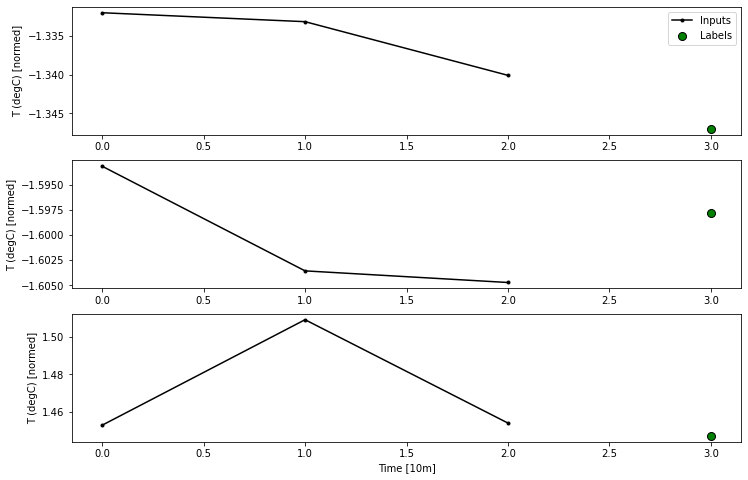

In [43]:
multi_window.plot()

---
`layers.Flatten`을 모델 첫 번째 층으로 추가하면 `multi_window`에 대해서 `dense`모델을 훈련할 수 있습니다.

In [44]:
multi_dense = tf.keras.Sequential([
    
    # 입력(input) 모양을 변경합니다.
    # Shape : (time, features) => (time * features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 32, activation = 'relu'),
    tf.keras.layers.Dense(units = 32, activation = 'relu'),
    tf.keras.layers.Dense(units = 1),
    
    # 출력(output) 모양을 변경합니다.
    # Shape : (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1])])

In [45]:
history = model_fit(multi_dense, multi_window)

val_performance['Multi step dense'] = multi_dense.evaluate(multi_window.val)
performance['Multi step dense'] = multi_dense.evaluate(multi_window.test, verbose = 0)

Epoch 1/20
9200/9200 [==============================] - 12s 1ms/step - loss: 0.0148 - mean_absolute_error: 0.0535 - val_loss: 6.9555e-04 - val_mean_absolute_error: 0.0179
Epoch 2/20
9200/9200 [==============================] - 12s 1ms/step - loss: 8.2208e-04 - mean_absolute_error: 0.0203 - val_loss: 6.9291e-04 - val_mean_absolute_error: 0.0184
Epoch 3/20
9200/9200 [==============================] - 12s 1ms/step - loss: 7.2771e-04 - mean_absolute_error: 0.0188 - val_loss: 7.6250e-04 - val_mean_absolute_error: 0.0189
Epoch 4/20
9200/9200 [==============================] - 12s 1ms/step - loss: 6.9220e-04 - mean_absolute_error: 0.0182 - val_loss: 6.5309e-04 - val_mean_absolute_error: 0.0176
Epoch 5/20
9200/9200 [==============================] - 12s 1ms/step - loss: 6.6867e-04 - mean_absolute_error: 0.0178 - val_loss: 5.9757e-04 - val_mean_absolute_error: 0.0161
Epoch 6/20
9200/9200 [==============================] - 12s 1ms/step - loss: 6.5820e-04 - mean_absolute_error: 0.0177 - val_loss:

이에대한 입력(input)과 라벨(label)을 그래프로 나타내면 다음과 같습니다.

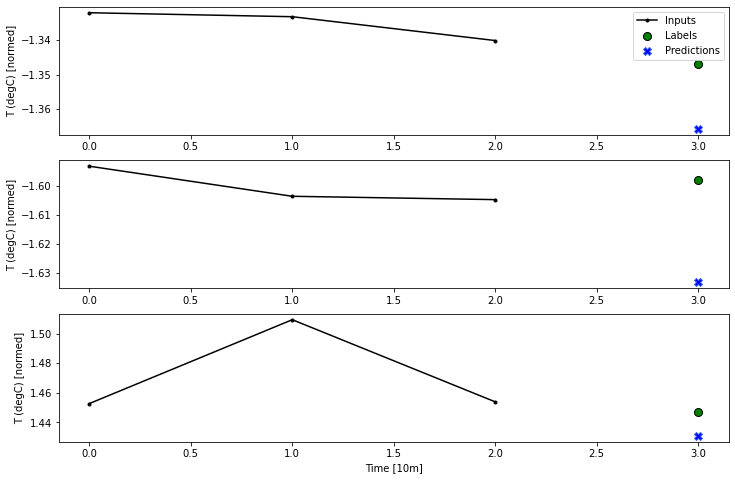

In [46]:
multi_window.plot(multi_dense)

다만 이러한 접근법의 경우 모델에서 받는 입력(input)의 모양(shape)이 입력 창(input window)의 모양(shape)과 정확히 동일해야만 사용할 수 있다는 단점이 있습니다.

이러한 단점은 컨볼루션(convolution) 모델을 사용하여 해결할 수 있습니다.

---
## 컨볼루션 신경망(Convolution neural network, CNN)

컨볼루션 층인 `layers.Conv1D`도 각 예측에 대하여 입력(input)으로 여라 타임스텝을 사용합니다.

다음은 `multi_dense`모델과 동일하지만 컨볼루션으로 다시 작성한 모델입니다.

변경사항은 다음과 같습니다.

- `multi_dense`모델에서의 `layers.Flatten`와 첫번째 밀집층인`layers.Dense`는 `layers.Conv1D`로 대체됩니다.
- 컨볼루션이 출력(output)의 모양을 결정하기 때문에, `layers.Reshape`는 사용하지 않습니다.

In [47]:
CNN_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32,
                          kernel_size = (3, ),
                          activation = 'relu'),
    tf.keras.layers.Dense(units = 32, activation = 'relu'),
    tf.keras.layers.Dense(units = 1)
])

기존의 데이터 창(window)인 `multi_window`를 `CNN_model`에 적용시켜 훈련하고, 평가를 수행합니다.

In [48]:
history = model_fit(CNN_model, multi_window)

IPython.display.clear_output()
val_performance['Conv'] = CNN_model.evaluate(multi_window.val)
performance['Conv'] = CNN_model.evaluate(multi_window.test, verbose = 0)

2629/2629 [==============================] - 3s 1ms/step - loss: 6.2558e-04 - mean_absolute_error: 0.0171


`CNN_model`, `multi_dense`의 차이점은 모델에서 받는 입력(input)의 모양(shape)이 입력 창(input window)의 모양(shape)과 정확히 동일해야만 사용할 수 있었던 `multi_dense`모델에 비해, `CNN_model`은 모든 입력(input)의 모양(shape)에 대해 실행할 수 있다는 것입니다.

컨볼루션 신경망(CNN)을 표현하면 다음과 같습니다.

![CNN model](images/09_multistepdense.PNG)

더 넓은 모양을 가지는 입력(input)에 대해서 학습하면, 더 넓은 출력(output)이 생성됩니다.

또한, `CNN_model`은 출력(output)의 길이가 입력(input)의 길이보다 짧기 때문에 `layers.Conv1D`의 `kernel_size`길이에 대한 타임스텝을 추가하여 `wide_CNN_window`를 생성합니다.

In [49]:
wide_CNN_window = Window(
    input_width = 12 + (3 - 1),
    label_width = 12, offset = 1,
    label_columns = ['T (degC)'])

wide_CNN_window

Total Width : 15
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices : [ 3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s) : ['T (degC)']

이제 더 넓은 모양을 가지는 모델에 대해서 예측값을 다음과 같은 그래프로 나타낼 수 있습니다.

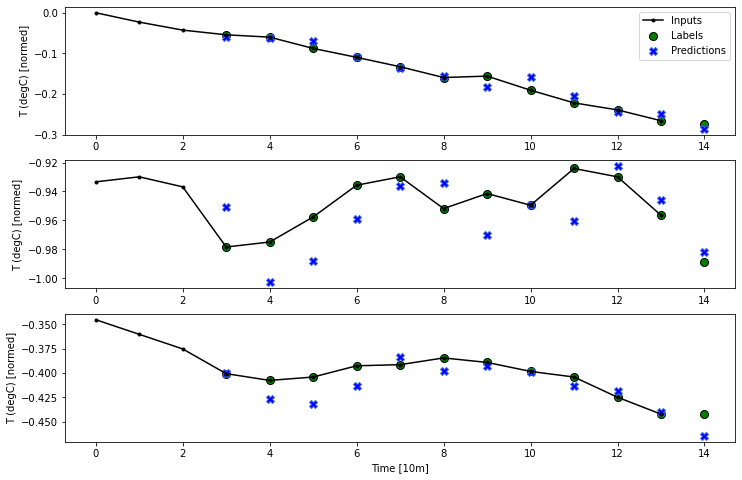

In [50]:
wide_CNN_window.plot(CNN_model)

그래프의 모든 예측은 이전의 3개의 타임스텝에 기초하여 수행합니다.

---
## 순환 신경망(Recurrent neural network, RNN)

순환 신경망(Recurrent neural network, RNN)은 시계열 데이터에 적합한 신경망 유형입니다. 순환 신경망(RNN)은 시계열을 단계별로 처리하면서 타임스텝과 타임스텝 사이에서, 현재 타임스텝의 모델 내부상태를 다음 타임스텝의 모델에 전달하여 유지합니다.

이번 튜토리얼에서는 [Long Short Term Memory]([link])(LSTM)이라는 RNN 층을 사용합니다.

[link]: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM

RNN 모델에 대한 중요한 파라미터는 `return_sequences`입니다. 이 파라미터를 사용하여 다음 두 가지 방법 중 하나로 모델을 구성할 수 있습니다.

1. `return_sequences = False`인 경우 마지막 타임스텝에 대한 출력(output)만 반환하여 단일 예측을 수행합니다.

![RNN model1](images/10_rnn.PNG)

2. `return_sequences = True`인 경우 각 타임스텝의 입력(input)에 대한 출력(output)을 반환합니다.

![RNN model1](images/11_rnn2.PNG)

`return_sequences = True` 모델을 생성하여 훈련을 수행하겠습니다.

In [51]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(units = 1)
])

In [52]:
history = model_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose = 0)

2629/2629 [==============================] - 3s 1ms/step - loss: 5.1096e-04 - mean_absolute_error: 0.0147


예측 결과를 그래프로 나타내면 다음과 같습니다.

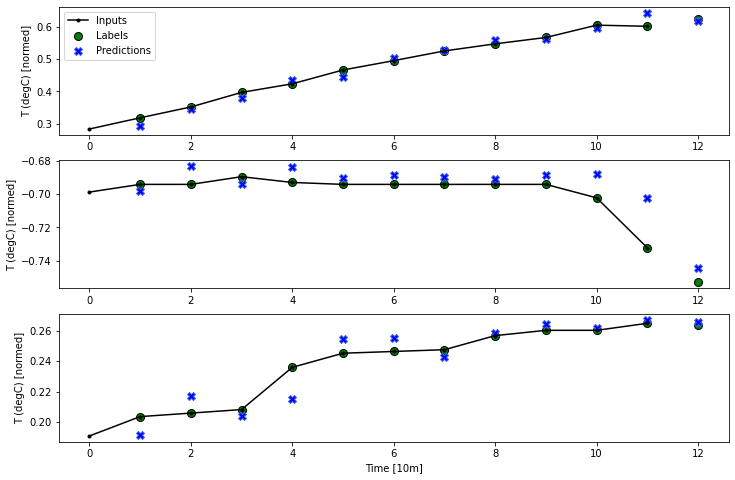

In [53]:
wide_window.plot(lstm_model)

---
## 성능(Performance)

앞서 훈련한 모델들에 대한 예측 성능을 비교합니다.

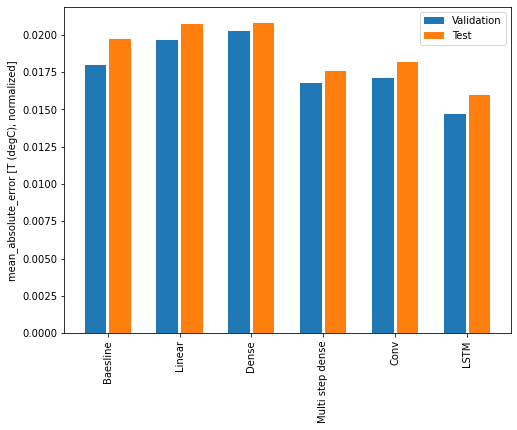

In [54]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label = 'Validation')
plt.bar(x + 0.17, test_mae, width, label = 'Test')
plt.xticks(ticks = x, labels = performance.keys(), rotation = 90)
_ = plt.legend()

In [55]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baesline    : 0.0197
Linear      : 0.0207
Dense       : 0.0208
Multi step dense: 0.0176
Conv        : 0.0182
LSTM        : 0.0160


---
## 다중 출력 모델(Multi-output models)

이전까지 모델에서는 `Window`클래스에서 `label_columns`를 입력하여 단일 출력인 `T (degC)`에 대한 예측을 수행하였습니다. 이러한 모든 모델에 대해서 출력(output) 층, 데이터 창(window), `label_columns`를 조정하여 여러 특성들을 예측하도록 변환할 수 있습니다.

In [56]:
# 모든 특성에 대하여 데이터 창을 생성하려면 label_columns를 입력하지 않습니다.
single_step_window = Window(
    input_width = 1, label_width = 1, offset = 1)

wide_window = Window(
    input_width = 12, label_width = 12, offset = 1)

### Baseline

In [57]:
baseline = Baseline()
baseline.compile(loss = tf.losses.MeanSquaredError(),
                metrics = [tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose = 0)

2629/2629 [==============================] - 3s 1ms/step - loss: 0.0346 - mean_absolute_error: 0.0792


### Dense

In [58]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = num_features)
])

history = model_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose = 0)

2629/2629 [==============================] - 3s 966us/step - loss: 0.0323 - mean_absolute_error: 0.0828


### RNN

In [59]:
%%time
# 이후 진행될 Residual connections와의 비교를 위하여 훈련에 소요되는 시간 체크

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(units = num_features)
])

history = model_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose = 0)

print()

2629/2629 [==============================] - 3s 1ms/step - loss: 0.0295 - mean_absolute_error: 0.0763

CPU times: user 6min 15s, sys: 3min 59s, total: 10min 14s
Wall time: 3min 10s


---
### Residual connections

이전 `Baseline`모델은 시퀀스가 타임스텝 사이에서 크게 변하지 않는다는 사실을 이용하였습니다. 지금까지 훈련한 모든 모델은 초기상태가 임의로 정해지기 때문에, 출력(output)은 이전 타임스텝에서 약간의 변화가 발생한다는 것 이용하여 학습을 수행하였습니다. 그렇기 때문에 임의로 정해지는 초기상태에 따라 학습 결과가 크게 달라질 수 있습니다.

이러한 문제를 쉽게 해결하기 위한 간단한 방법은 모댈 구조를 변경하는것 입니다.

시계열 데이터를 분석할 때 단순히 다음 값을 예측하기 보다는, 다음 타입스텝이서 값이 얼만큼 변화하였는지 확인하는 모델을 생성하는 것이 일반적입니다. 이에 대해 'Residual networks' 또는 'ResNets'를 사용하여 딥러닝의 각 층에 모델의 누적 결과를 추가하여 학습을 수행합니다.

![Residual connections](images/12_residualconnections.PNG)

기본적으로 `Baseline`과 일치하도록 모델의 초기상태를 설정합니다. 그리고 Residual connections를 활용하면 모델이 대해 기존보다 더 우수한 성능을 나타내며, 수렴하는데 걸리는 시간을 감소시킬 수 있습니다.

이 방법은 이번 튜토리얼에서 사용되었던 모든 모델에 적용할 수 있습니다.

여기서는 LSTM모델에 적용하도록 하겠습니다.

Residual connection에 대한 클래스를 정의합니다. 각각의 타임스텝에 대한 예측값은 이전 타음스텝에서의 입력(input)에 모델에 의해 계산된 delta를 더한 값 입니다.

In [60]:
class ResidualConnection(tf.keras.Model) :
    def __init__(self, model) :
        super().__init__()
        self.model = model
        
    def call(self, inputs, *args, **kwargs) :
        delta = self.model(inputs, *args, **kwargs)
        
        return inputs + delta

In [61]:
%%time
residual_lstm = ResidualConnection(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(
        num_features,
        kernel_initializer = tf.initializers.zeros)
    ]))

history = model_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose = 0)

print()

2629/2629 [==============================] - 3s 1ms/step - loss: 0.0296 - mean_absolute_error: 0.0749

CPU times: user 4min 12s, sys: 2min 45s, total: 6min 57s
Wall time: 2min 6s


이전 LSTM모델을 학습시키는데 걸렸던 시간보다 더 적은 시간이 걸리는 것을 확인 할 수 있습니다.

### 성능(Performacne)

다음은 이러한 다중 출력 모델의 전반적인 성능을 비교한 것입니다.

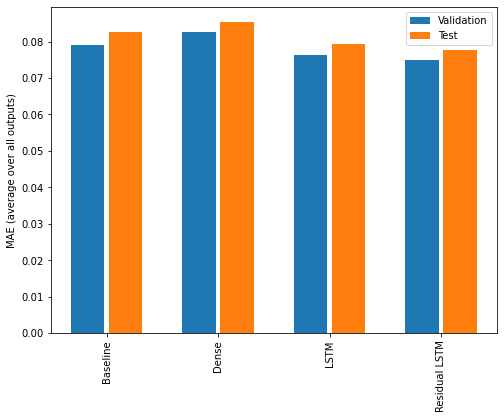

In [62]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label = 'Validation')
plt.bar(x + 0.17, test_mae, width, label = 'Test')
plt.xticks(ticks = x, labels = performance.keys(),
          rotation = 90)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

Residual LSTM모델의 성능은 기존의 LSTM의 성능과 유사하거나 조금 더 우수한 것을 확인할 수 있습니다.

---
## 다중 스텝 모델(Multi-step models)

이전까지의 모델은 모두 단일 출력 및 다중 출력에 대해 미래 1개의 단일 타임스텝 예측을 수행하였습니다.

이번에는 단일 타임스텝 모델을 확장하여 다중 타임스텝 예측을 수행하는 모델을 생성합니다.

다중 타임스텝 예측에서 모델은 일정 범위의 미래 값을 예측하는 방법을 학습해야 합니다. 따라서 한 미래 시점만 예측하는 단일 스텝 모델과 달리 다중 스텝 모델은 미래 값의 시퀀스를 예측해야 합니다.

다중 스텝 모델에 대한 접근법은 크게 두 가지가 있습니다.

1. 전체 시계열이 한 번에 예측되는 싱글샷(single shot) 모델

2. 모델이 단일 스텝 예측을 수행하지만, 해당 출력값이 입력으로 다시 피드백 되는 자기 회귀 예측(autoregressive prediction) 모델

이를 활용하여 과거의 2시간(12개의 타임스텝)을 고려하여 미래의 2시간(12개의 타입스텝)을 예측하는 방법을 학습합니다.

다음은 이를 위한 데이터 창(window)을 생성하는 과정입니다.

Total Width : 24
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices : [12 13 14 15 16 17 18 19 20 21 22 23]
Label column name(s) : None

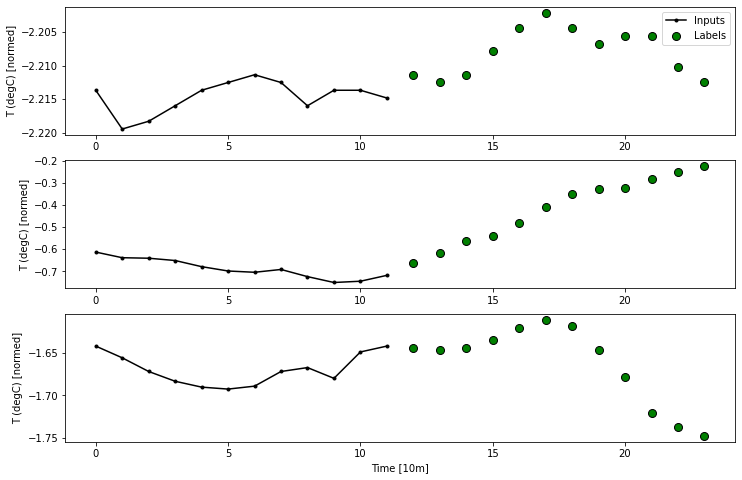

In [63]:
multi_steps = 12
multi_window = Window(input_width = 12,
                     label_width = multi_steps,
                     offset = multi_steps)

multi_window.plot()
multi_window

---
### Baseline

이번 모델을 위한 가장 간단한 기준은 출력(output) 타임스텝 수에 만큼 마지막 입력(input) 타임스텝을 반복하는 것입니다.

![Multi Baseline](images/13_multibaseline.PNG)

2628/2628 [==============================] - 3s 1ms/step - loss: 0.1062 - mean_absolute_error: 0.1701


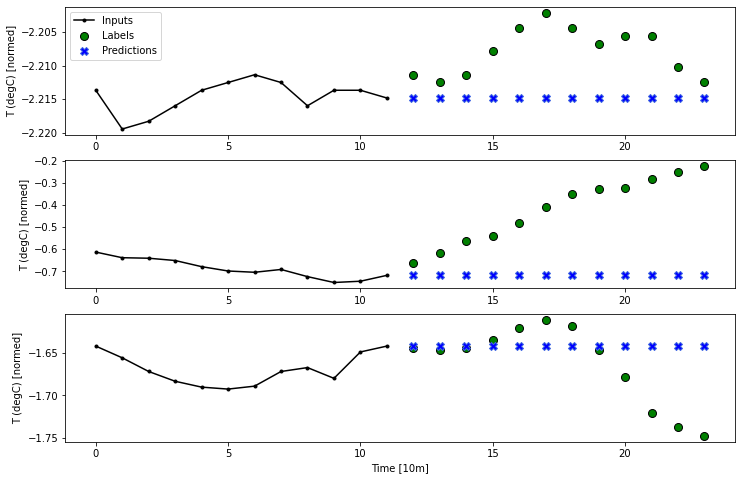

In [64]:
class LastBaseline(tf.keras.Model) :
    def call(self, inputs) :
        return tf.tile(inputs[:, -1:, :], [1, multi_steps, 1])
    
last_baseline = LastBaseline()
last_baseline.compile(loss = tf.losses.MeanSquaredError(),
                           metrics = [tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last Baseline'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last Baseline'] = last_baseline.evaluate(multi_window.val, verbose = 0)
multi_window.plot(last_baseline)

과거 3시간의 데이터가 주어졌을 때, 2시간 후 미래를 예측하는 또 다른 접근 방법은 과거 2시간의 데이터를 반복하는 것입니다.

![Multi Baseline2](images/14_multibaseline2.PNG)

2628/2628 [==============================] - 3s 1ms/step - loss: 0.1671 - mean_absolute_error: 0.2374


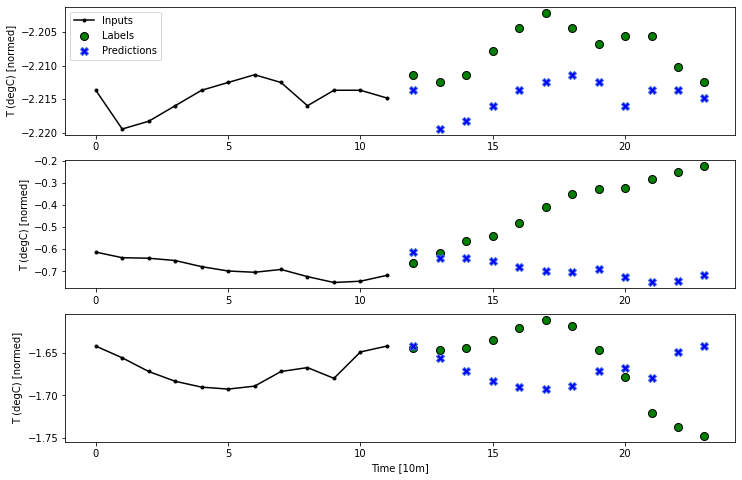

In [65]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs
    
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss = tf.losses.MeanSquaredError(),
                       metrics = [tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat Baseline'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat Baseline'] = repeat_baseline.evaluate(multi_window.test, verbose = 0)
multi_window.plot(repeat_baseline)

---
## 싱글샷(Single-shot) 모델

이러한 다중 스텝 모델에서 기준(baseline)모델보다 높은 수준의 접근 방법 모델이 한 번에 전체 시퀀스 예측을 수행하는 '싱글샷(single-shot)'모델을 사용하는 것입니다.

싱글샷 모델에서 `multi_steps * num_features`모양의 출력 단위를 사용해 `layers.Dense`를 구현할 수 있습니다.

---
### 선형(Linear)

마지막 입력 타임스텝을 기반으로 하는 단순한 선형 모델은 기존 모델보다 성능이 좋긴 하지만 다중 스텝 예측에 대해서 가장 높은 성능을 나타내지는 못합니다. 이는 선형 모델을 이용하여 단일 입력 타입스텝으로부터 `multi_steps` 타임스텝을 예측해야 합니다.

![Multi Linear](images/15_multilinear.PNG)

2628/2628 [==============================] - 3s 1ms/step - loss: 0.0954 - mean_absolute_error: 0.1667


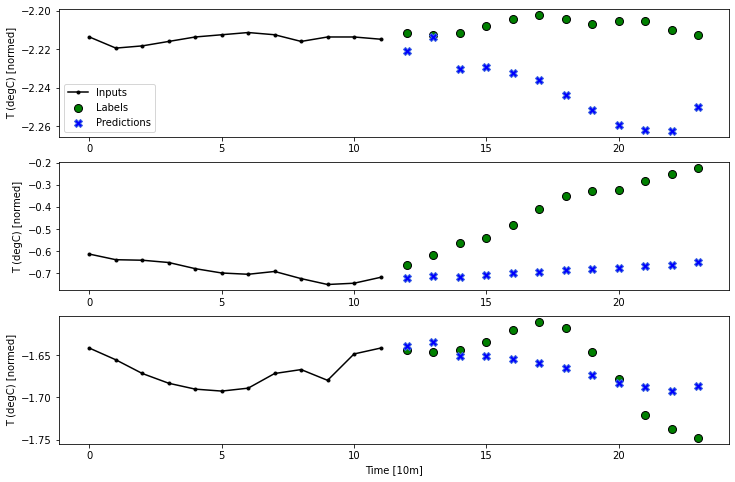

In [66]:
multi_linear_model = tf.keras.Sequential([
    
    # 마지막 입력 타임스텝을 받아 입력 모양을 변경합니다.
    # Shape : (batch, time, features) => (batch, 1, features)
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(multi_steps * num_features,
                         kernel_initializer = tf.initializers.zeros),
    tf.keras.layers.Reshape([multi_steps, num_features])
])

history = model_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose = 0)
multi_window.plot(multi_linear_model)

---
### Dense

입력(input)과 출력(output) 사이에 `layers.Dense`를 추가하면 단일 입력에 기반하지만 기존의 선형 모델보다는 더 높은 성능을 나타냅니다.

2628/2628 [==============================] - 3s 1ms/step - loss: 0.0913 - mean_absolute_error: 0.1645


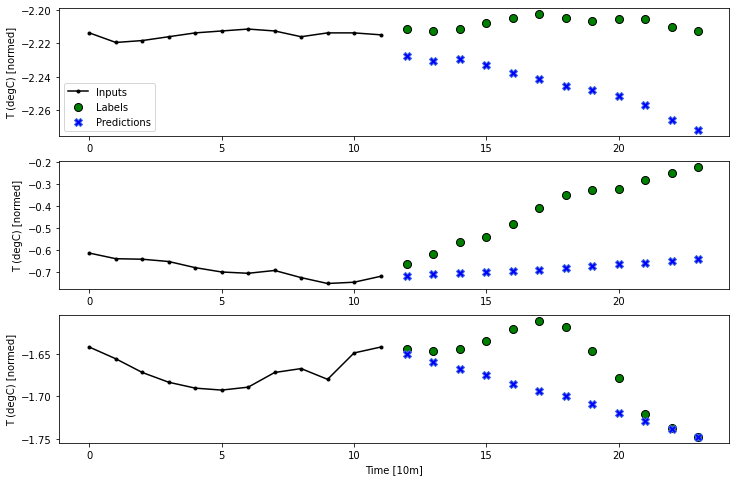

In [67]:
multi_dense_model = tf.keras.Sequential([
    
    # 마지막 입력 타임스텝을 받아 입력 모양을 변경합니다.
    # Shape : (batch, time, features) => (batch, 1, features)
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    
    # Shape => (batch, 1, dense_units)
    tf.keras.layers.Dense(512, activation = 'relu'),
    
    # Shape => (batch, multi_steps * num_features)
    tf.keras.layers.Dense(multi_steps * num_features,
                         kernel_initializer = tf.initializers.zeros),
    
    # Shape => (batch, multi_steps, num_features)
    tf.keras.layers.Reshape([multi_steps, num_features])
])

history = model_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose = 0)
multi_window.plot(multi_dense_model)

---
### CNN

컨볼루션 모델은 고정 너비를 기반으로 예측을 수행하기 때문에, 타임스텝에 따른 변화를 파악할 수 있어 Dense 모델보다 더 높은 성능을 낼 수 있습니다.

![Multi CNN](images/16_cnn.PNG)

2628/2628 [==============================] - 3s 993us/step - loss: 0.0839 - mean_absolute_error: 0.1551


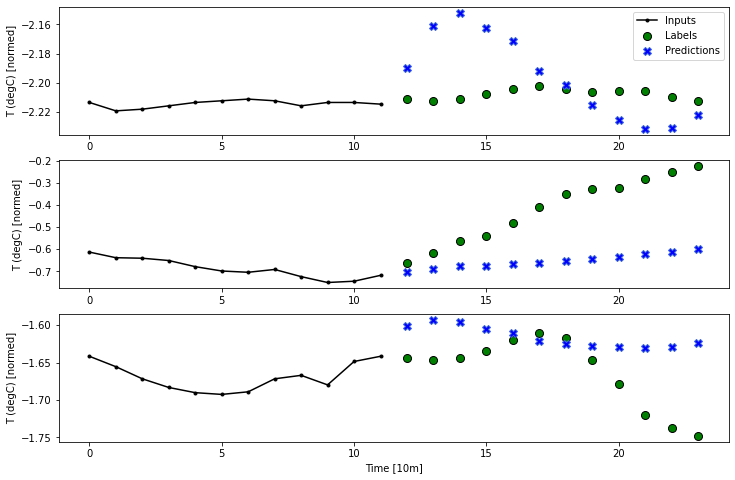

In [68]:
# CNN 모델의 convolution width = 3
multi_CNN_model = tf.keras.Sequential([
    
    # Shape : (batch, time, features) => (batch, convolution width, num_features)
    tf.keras.layers.Lambda(lambda x: x[:, -3:, :]),
    
    # Shape => (batch, 1, conv_unit)
    tf.keras.layers.Conv1D(256, activation = 'relu', kernel_size = 3),
    
    # Shape => (batch, 1, multi_steps * num_features)
    tf.keras.layers.Dense(multi_steps * num_features,
                         kernel_initializer = tf.initializers.zeros),
    
    # Shape => (batch, multi_steps, num_features)
    tf.keras.layers.Reshape([multi_steps, num_features])
])

history = model_fit(multi_CNN_model, multi_window)

IPython.display.clear_output()

multi_val_performance['CNN'] = multi_CNN_model.evaluate(multi_window.val)
multi_performance['CNN'] = multi_CNN_model.evaluate(multi_window.test, verbose = 0)
multi_window.plot(multi_CNN_model)

---
### RNN

순환 모델은 긴 입력 기록을 사용하여 학습을 수행하고 미래를 예측할 수 있습니다. 이때 모델은 다음 3시간 후에 대한 예측을 수행하기 전에, 이전 3시간 동안의 타임스텝에 대해 처리하면서 현재 내부상태를 다음 타임스텝에 전달하며 유지합니다.

싱글샷 형태의 모델에서의 LSTM 모델은 마지막 타임스텝에서만 출력을 생성하기 때문에 `return_sequences = False`로 설정합니다.

![Multi RNN](images/17_multirnn.PNG)

2628/2628 [==============================] - 3s 1ms/step - loss: 0.0795 - mean_absolute_error: 0.1496


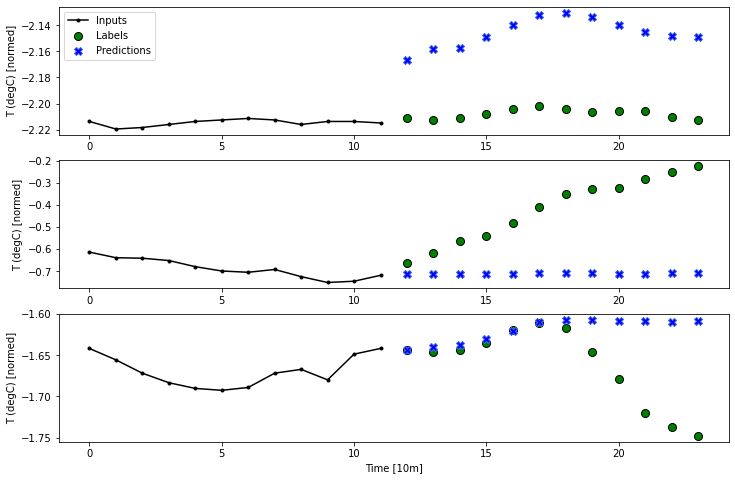

In [69]:
multi_lstm_model = tf.keras.Sequential([
    
    # Shape : (batch, time, features) => (batch, lstm_units)
    tf.keras.layers.LSTM(32, return_sequences = False),
    
    # Shape => (batch, multi_steps, num_features)
    tf.keras.layers.Dense(multi_steps * num_features,
                         kernel_initializer = tf.initializers.zeros),
    
    # Shape => (batch, multi_steps, num_features)
    tf.keras.layers.Reshape([multi_steps, num_features])
])

history = model_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose = 0)
multi_window.plot(multi_lstm_model)

---
## 자기 회귀 모델(Autoregressive model)

앞선 모델들의 경우 한 번에 전체 시퀀스를 예측합니다. 하지만 경우에 따라서 모델이 예측을 여러 타임스텝으로 분배하는 것이 유리할 수 있습니다. 이를 활용하면 이전의 RNN모델의 시퀀스 생성에서, 각 모델에서의 출력을 각 타입스텝에서 자체 피드백을 할 수 있습니다.

![Autoregressive Model](images/18_autoregressive.PNG)

---
### RNN

이번 튜토리얼에서는 자기 회귀 RNN 모델을 생성하지만, 자기 회귀 모델은 단일 타임스텝을 출력하도록 되어있는 모든 모델에 적용할 수 있습니다.

이 모델은 단일 스텝 LSTM모델과 기본 형대가 동일하기 때문에, LSTM모델에서 나온 출력을 모델의 예측으로 변환하는 `layers.Dense`가 추가됩니다.

이번 모델에서는 각 스텝에 대한 입력을 수동으로 관리해야 하므로 결과를 자동으로 관리하는 높은 수준의 `layers.LSTM`보다 낮은 수준의 `layers.LSTMCell`을 직접 사용합니다(자세한 내용은 [Keras RNN]([link]) 참조).

[link]: https://www.tensorflow.org/guide/keras/rnn

In [70]:
class FeedBack(tf.keras.Model) :
    def __init__(self, units, multi_steps) :
        super().__init__()
        self.multi_steps = multi_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        
        # 'warmup' 방법을 사용하여 LSTMCell을 RNN으로 wrap
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state = True)
        self.dense = tf.keras.layers.Dense(num_features)

In [71]:
feedback_model = FeedBack(units = 32, multi_steps = multi_steps)

현재 모델에서 필요로 하는것은 입력을 기반으로 내부상태를 초기화하는 `warmup`입니다. 훈련이 되면 이 내부상태는 입력 기록에 관련 부분을 캡처하며, 이는 앞선 단일 스텝 LSTM 모델과 동일합니다.

In [80]:
def warmup(self, inputs) :
    
    # input.shape => (batch, time, num_features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)
    
    # prediction.shape => (batch, num_features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

다음 단계에서는 단일 타임스텝 예측과 LSTM의 내부상태를 반환합니다.

In [81]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 15])

RNN의 상태 및 초기 예측을 사용하여 이전 타음스텝에서 수행한 예측을 다음 타임스텝의 입력으로 전달하고, 이 과정을 반복할 수 있습니다.

출력에 대한 예측을 수집하는 가장 간단한 방법은 루프에서 list를 사용하고 `tf.stack`을 사용하는 것입니다.

In [85]:
def call(self, inputs, training = None) :
    
    predictions = []
    
    # lstm 상태를 초기화합니다.
    prediction, state = self.warmup(inputs)
    
    # 첫 번째 예측값을 추가합니다.
    predictions.append(prediction)
    
    # 나머지 예측을 반복수행 합니다.
    for n in range(1, self.multi_steps) :
        
        # 이전 예측값을 입력으로 사용합니다.
        x = prediction
        
        x, state = self.lstm_cell(x, states = state,
                                 training = training)
        
        # lstm 출력값을 예측값으로 전환합니다.
        prediction = self.dense(x)
        
        # 예측값을 출력에 추가합니다.
        predictions.append(prediction)
        
    # predictions.shape => (time, batch, num_features)
    predictions = tf.stack(predictions)
    
    # predictions.shape => (batch, time, num_features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

모델을 훈련합니다.

2628/2628 [==============================] - 7s 3ms/step - loss: 0.0818 - mean_absolute_error: 0.1563


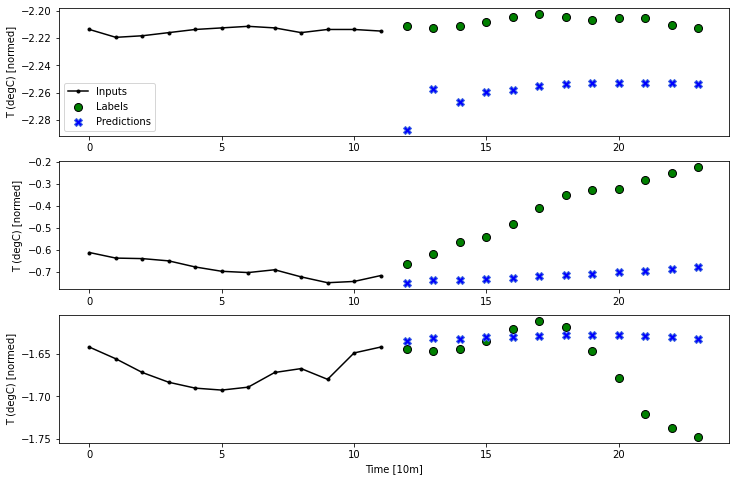

In [86]:
history = model_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AutoRegressive LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AutoRegressive LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
multi_window.plot(feedback_model)

---
### 성능(Performance)

다중 스텝 모델에 대한 전반적인 성능을 비교합니다.

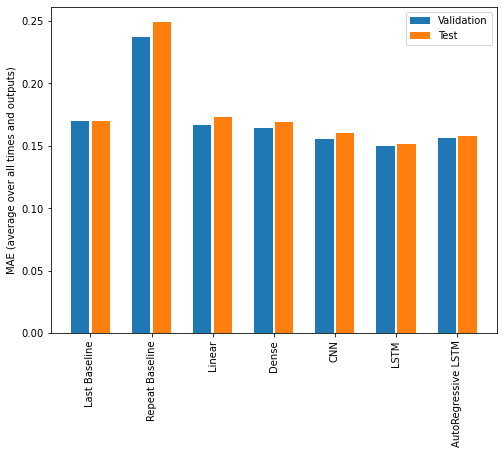

In [88]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label = 'Validation')
plt.bar(x + 0.17, test_mae, width, label = 'Test')
plt.xticks(ticks = x, labels = multi_performance.keys(),
          rotation = 90)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [90]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last Baseline: 0.1701
Repeat Baseline: 0.2490
Linear  : 0.1732
Dense   : 0.1694
CNN     : 0.1599
LSTM    : 0.1515
AutoRegressive LSTM: 0.1580


이번 시계열 데이터에 대해서는 자기 회귀 LSTM 모델의 성능이 기존 LSTM의 성능보다 낮게 나타났지만, 이러한 모델은 다른 특정 문제에는 더 높은 성능을 나타낼 수 있습니다.

이번 튜토리얼에서는 시계열 날씨 데이터에 대해 TensorFlow를 사용하여 학습하고, 다양한 모델을 활용하여 시계열 예측을 수행하였습니다. 이후 다양한 모델에 대한 예측 성능을 비교하고, 가장 높은 성능을 나타내는 모델은 무엇인지 확인 할 수 있었습니다.

이를 통하여 추후 다른 종류의 시계열 데이터를 다룰 때, 높은 성능을 발휘하는 모델을 선택하는데 도움이 될 것입니다.